<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto tem o intuito de estudar Técnicas de Modelagem de Risco de Crédito. </i>       
</p>  

# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [ ]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import bernoulli, binom, poisson, geom, norm, chi2, f, chi2_contingency, normaltest, ttest_ind, ttest_rel, wilcoxon, mannwhitneyu, kruskal
import math
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px 
import plotly.graph_objects as go
import importlib
import transition_matrix_estimator
from transition_matrix_estimator import TransitionMatrixLearner
import time
import datetime
import warnings
import category_encoders as ce 
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# <font color='orange' style='font-size: 40px;'> Exemplo Montagem de Target </font>
<hr style='border: 2px solid orange;'>

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

> 1. Testes de Continuidade: Verificação da consistência temporal dos dados por contrato (sem quebras ou lacunas indevidas).

> 2. Criação da Coluna flag_acordo: Identificação de registros com acordos ou renegociações.

> 3. Criação da Coluna over90: Flag mensal de inadimplência grave (atraso superior a 90 dias).

> 4. Criação da Coluna mau: Identificação de contratos irrecuperáveis com base em regras de negócio.

> 5. Construção do Grupo Performing: Definição da amostra elegível para modelagem de PD, com base no status performing.

> 6. Criação da Coluna ever90m12: Indica se o contrato atingiu atraso >90 dias em qualquer mês dos próximos 12 meses (sem considerar acordos).

> 7. Criação da Coluna over90m12: Indica se o contrato está em atraso >90 dias ao final da janela futura de 12 meses (sem considerar acordos).

> 8. Criação da Coluna target: Flag final de inadimplência futura, considerando tanto atraso quanto acordos.

> 9. Congelamento do Snapshot de Contratos: Seleção de uma linha por contrato para representar o momento de avaliação (janela de decisão).

> 10. Curva de Inadimplência (over90) por Mês: Análise temporal do volume de contratos inadimplentes mês a mês (painel e snapshot).

> 11. Curvas de ever90m12 e over90m12 por Mês: Evolução mensal dos indicadores prospectivos de risco (apenas painel).

> 12. Construção da Matriz de Transição: Avaliação da migração de status de crédito entre períodos (ex: performing → inadimplente).

> 13. Construção da Curva de Cura: Medição da recuperação de contratos inadimplentes ao longo do tempo.

### 1.1.1) Entendimento de Conceitos

> 1. data_inicio_contrato

- É a data que o cliente e o banco firmaram acordo, como por exemplo 2014-09-30
- Em muitos casos, existe "carência" até o 1 vencimento, portanto, o contrato existe juridicamente mas não dá para medir performance ainda

> 2. safra:

- Mês de nascimento da performance (M0)
- Se a primeira parcela vence em jan/2025, o contrato é marcado como safra de 201501

> 3. dat_ref:

- A cada dat_ref (foto mensal), o contrato é monitorado
- A safra nunca muda, porque é o "carimbo" da geração

In [57]:
historico  = pd.read_parquet('./data/full_history.parquet')
historico['safra'] = historico.groupby('id_contrato')['data_ref'].transform('min')
historico = historico[['id_contrato','data_inicio_contrato', 'safra', 'data_ref','dias_atraso']]
historico.sort_values(by=['id_contrato','data_ref'], inplace=True)
historico['data_ref'] = pd.to_datetime(historico['data_ref'])


rastro_contratos = pd.read_parquet('./data/rastro_contratos.parquet')
rastro_contratos.sort_values(by=['id_antigo'], inplace=True)
rastro_contratos['data_evento'] = pd.to_datetime(rastro_contratos['data_evento'])
rastro_contratos.rename(columns={'id_antigo': 'id_contrato', 'data_evento': 'data_inicio_contrato'}, inplace=True)

display(historico.head(15))
display(rastro_contratos.head(15))



,id_contrato,data_inicio_contrato,safra,data_ref,dias_atraso
0,10000000,2014-09-30,2015-01-01,2015-01-01,30
1,10000000,2014-09-30,2015-01-01,2015-02-01,15
2,10000000,2014-09-30,2015-01-01,2015-03-01,15
3,10000000,2014-09-30,2015-01-01,2015-04-01,30
4,10000000,2014-09-30,2015-01-01,2015-05-01,60
5,10000000,2014-09-30,2015-01-01,2015-06-01,90
6,10000000,2014-09-30,2015-01-01,2015-07-01,60
7,10000000,2014-09-30,2015-01-01,2015-08-01,90
8,10000000,2014-09-30,2015-01-01,2015-09-01,90
9,10000000,2014-09-30,2015-01-01,2015-10-01,60


,id_contrato,id_novo,data_inicio_contrato
1023,10000000,10004583,2015-12-01
368,10000001,10003338,2015-06-01
706,10000002,10003996,2015-09-01
0,10000003,10002500,2015-02-01
255,10000007,10003118,2015-05-01
1366,10000009,10005220,2016-03-01
815,10000010,10004198,2015-10-01
55,10000011,10002680,2015-03-01
816,10000013,10004199,2015-10-01
256,10000015,10003119,2015-05-01


### 1.1.2) Flag de Renegociação   

> 1. Renegociação é quando o cliente não consegue mais horar o contrato original e o banco faz um novo acordo para tentar recuperar o crédito. Exemplo:

- O cliente estava atrasado várias parcelas
- Ao invés do banco contabilizar uma perda efetivamente, o banco oferece uma renegociação:
    - Pode reparcelar o saldo devedor em novas condições de prazos
    - Pode descontar parte da dívida
    - Pode dar carência antes de retomar os pagamentos
- Nesses casos, o ID do contrato geralmente muda e o novo ID carrega a dívida renegociada

In [58]:
historico['flag_acordo'] = 0

rastro_contratos["safra"] = np.nan
rastro_contratos["data_ref"] = np.nan
rastro_contratos["dias_atraso"] = np.nan
rastro_contratos['flag_acordo'] = 1
rastro_contratos = rastro_contratos[['id_contrato', 'data_inicio_contrato', 'safra', 'data_ref', 'dias_atraso', 'flag_acordo']]

df = pd.concat([historico, rastro_contratos])
df.sort_values(by=['id_contrato','data_ref'], inplace=True)
df = df.reset_index(drop=True)
df.head(15)

,id_contrato,data_inicio_contrato,safra,data_ref,dias_atraso,flag_acordo
0,10000000,2014-09-30,2015-01-01,2015-01-01,30.0000,0
1,10000000,2014-09-30,2015-01-01,2015-02-01,15.0000,0
2,10000000,2014-09-30,2015-01-01,2015-03-01,15.0000,0
3,10000000,2014-09-30,2015-01-01,2015-04-01,30.0000,0
4,10000000,2014-09-30,2015-01-01,2015-05-01,60.0000,0
5,10000000,2014-09-30,2015-01-01,2015-06-01,90.0000,0
6,10000000,2014-09-30,2015-01-01,2015-07-01,60.0000,0
7,10000000,2014-09-30,2015-01-01,2015-08-01,90.0000,0
8,10000000,2014-09-30,2015-01-01,2015-09-01,90.0000,0
9,10000000,2014-09-30,2015-01-01,2015-10-01,60.0000,0


### 1.1.3) Criação de Mau Origem, Over e Ever

> 1. Desconsideraremos a Flag de Acordo pois eu só conseguiria marcar Mau Origem, Over e Ever mediante a saber quantos dias de atraso o novo contrato possui

> 2. Em termos práticos:

| Tipo     | Uso         | Exemplo                                                         |
| -------- | ----------- | --------------------------------------------------------------- |
| Snapshot | Application | “Este cliente, até o mês corrente, já atrasou >30 dias?”        |
| Painel   | Behaviour   | “Este cliente, em algum momento do contrato, atrasou >30 dias?” |


In [59]:
df = pd.concat([historico, rastro_contratos])
df = df.loc[df['flag_acordo'] == 0]
df.sort_values(by=['id_contrato','data_ref'], inplace=True)
df.head(15)

# 1) Definir safra e idade em meses
df['idade_meses_contrato'] =df['data_ref'].dt.to_period('M').astype(int) - df['safra'].dt.to_period('M').astype(int)

# ==========================
# MAU_ORIGEM (exemplo: >30 dias em M0)
# ==========================

df['flag_mau_origem'] = np.where((df['dias_atraso'] >= 30) & (df['idade_meses_contrato'] == 0), 1, 0)
df['mau_origem'] = df.groupby('id_contrato')['flag_mau_origem'].transform('max')
df.drop(columns=['flag_mau_origem'], inplace=True)


# --------------------------
# EVER30M6
# --------------------------

# 1) Linha a linha → 1 apenas nas referências que bateram o limiar
df['ever30m6_snapshot'] = np.where((df['dias_atraso'] >= 30) & (df['idade_meses_contrato'] <= 6),1, 0)

# 2) Contrato inteiro → 1 se em algum mês bateu o limiar
df['ever30m6_painel'] = df.groupby('id_contrato')['ever30m6_snapshot'].transform('max')

# --------------------------
# EVER30M12
# --------------------------

# 1) Linha a linha → 1 apenas nas referências que bateram o limiar
df['ever30m12_snapshot'] = np.where((df['dias_atraso'] >= 30) & (df['idade_meses_contrato'] <= 12),1, 0)

# 2) Contrato inteiro → 1 se em algum mês bateu o limiar
df['ever30m12_painel'] = df.groupby('id_contrato')['ever30m12_snapshot'].transform('max')

df.head(15)


,id_contrato,data_inicio_contrato,safra,data_ref,dias_atraso,flag_acordo,idade_meses_contrato,mau_origem,ever30m6_snapshot,ever30m6_painel,ever30m12_snapshot,ever30m12_painel
0,10000000,2014-09-30,2015-01-01,2015-01-01,30.0000,0,0,1,1,1,1,1
1,10000000,2014-09-30,2015-01-01,2015-02-01,15.0000,0,1,1,0,1,0,1
2,10000000,2014-09-30,2015-01-01,2015-03-01,15.0000,0,2,1,0,1,0,1
3,10000000,2014-09-30,2015-01-01,2015-04-01,30.0000,0,3,1,1,1,1,1
4,10000000,2014-09-30,2015-01-01,2015-05-01,60.0000,0,4,1,1,1,1,1
5,10000000,2014-09-30,2015-01-01,2015-06-01,90.0000,0,5,1,1,1,1,1
6,10000000,2014-09-30,2015-01-01,2015-07-01,60.0000,0,6,1,1,1,1,1
7,10000000,2014-09-30,2015-01-01,2015-08-01,90.0000,0,7,1,0,1,1,1
8,10000000,2014-09-30,2015-01-01,2015-09-01,90.0000,0,8,1,0,1,1,1
9,10000000,2014-09-30,2015-01-01,2015-10-01,60.0000,0,9,1,0,1,1,1


### 1.1.4) Rolagem

In [66]:
# Curva de Performance por Safra - Cohort
bins = [0, 30, 60, 90, 120, float('inf')]
labels = ['1–30 dias','31–60 dias','61–90 dias','91–120 dias','>120 dias']
df['faixa_atraso'] = pd.cut(df['dias_atraso'], bins=bins, labels=labels, right=True)

matriz_cohort = df.groupby(['safra', 'faixa_atraso'])['id_contrato'].count().unstack(fill_value=0)
matriz_cohort_pct = matriz_cohort.div(matriz_cohort.sum(axis=1), axis=0) * 100

matriz_cohort_pct = matriz_cohort_pct.round(2)
display(matriz_cohort_pct)


# Matriz de Rolagem
bins = [0, 30, 60, 90, 120, float('inf')]
labels = ['1-30 dias','31-60 dias','61-90 dias','91-120 dias','>120 dias']
df['faixa_atraso'] = pd.cut(df['dias_atraso'], bins=bins, labels=labels, right=True)

# Ordene por contrato e data
df = df.sort_values(['id_contrato', 'data_ref'])

# Pegue a faixa de atraso do mês anterior
df['faixa_atraso_prev'] = df.groupby('id_contrato')['faixa_atraso'].shift(1)

# Considere apenas pares válidos (com mês anterior)
transicoes = df.dropna(subset=['faixa_atraso_prev', 'faixa_atraso'])

# Monte a matriz de transição
matriz_transicao = pd.crosstab(
    transicoes['faixa_atraso_prev'],
    transicoes['faixa_atraso'],
    normalize='index'
) * 100

display(matriz_transicao)

faixa_atraso,1–30 dias,31–60 dias,61–90 dias,91–120 dias,>120 dias
safra,,,,,
2015-01-01,41.7300,32.0800,16.1300,3.9700,6.1000
2015-02-01,50.6800,29.3300,14.3800,1.7800,3.8300
2015-03-01,49.2000,30.1000,15.2300,1.9600,3.5000
2015-04-01,48.6400,32.2400,14.6200,2.0800,2.4200
2015-05-01,50.8700,30.5400,14.1500,2.0600,2.3800
2015-06-01,48.2800,32.0500,14.9500,2.1500,2.5600
2015-07-01,47.4600,34.1800,13.8400,1.3700,3.1500
2015-08-01,48.4400,32.2300,13.8200,2.0000,3.5200
2015-09-01,51.7500,31.2100,13.3800,1.9000,1.7500


faixa_atraso,1-30 dias,31-60 dias,61-90 dias,91-120 dias,>120 dias
faixa_atraso_prev,,,,,
1-30 dias,84.3684,15.6316,0.0000,0.0000,0.0000
31-60 dias,9.0544,63.5413,27.4043,0.0000,0.0000
61-90 dias,0.0000,51.6292,48.3708,0.0000,0.0000
91-120 dias,0.0000,0.0000,40.2734,59.7266,0.0000
>120 dias,0.0000,0.0000,0.0000,19.6751,80.3249


# <font color='orange' style='font-size: 40px;'> Exemplo Inferência de Negados </font>
<hr style='border: 2px solid orange;'>

https://python.plainenglish.io/a-project-on-reject-inference-94a6858bc821

https://www.kaggle.com/code/shraddhacodes/credit-card-default-reject-inference-project

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

In [ ]:
def plot_histograms_by_flag(df, features, flag_col='FLAG_ACCEPTED', bins=20, max_cols=5):
    n = len(features)
    n_rows = math.ceil(n / max_cols)
    fig, axes = plt.subplots(n_rows, max_cols, figsize=(5*max_cols, 4*n_rows), sharey=False)
    axes = axes.flatten() if n > 1 else [axes]
    for i, feature in enumerate(features):
        for flag in sorted(df[flag_col].unique()):
            subset = df[df[flag_col] == flag][feature]
            axes[i].hist(subset.dropna(), bins=bins, alpha=1 if flag == 0 else 0.8, label=f'{flag_col}={flag}')
        axes[i].set_title(feature)
        axes[i].legend()
    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def calculate_psi_continuous(expected, actual, buckets=10):
    """Calcula o PSI para variáveis contínuas usando buckets."""
    breakpoints = np.percentile(expected.dropna(), np.linspace(0, 100, buckets + 1))
    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    psi = np.sum((expected_counts - actual_counts) * np.log((expected_counts + 1e-6) / (actual_counts + 1e-6)))
    return psi

def calculate_psi_categorical(expected, actual):
    """Calcula o PSI para variáveis categóricas."""
    expected_dist = expected.value_counts(normalize=True)
    actual_dist = actual.value_counts(normalize=True)
    all_categories = set(expected_dist.index).union(set(actual_dist.index))
    psi = 0
    for cat in all_categories:
        e = expected_dist.get(cat, 1e-6)
        a = actual_dist.get(cat, 1e-6)
        psi += (e - a) * np.log((e + 1e-6) / (a + 1e-6))
    return psi

def psi(df, features, flag_col='FLAG_ACCEPTED', buckets=10, plot=True, categorical_features=None):
    psi_list = []
    group0 = df[df[flag_col] == 0]
    group1 = df[df[flag_col] == 1]
    if categorical_features is None:
        categorical_features = []
    for feature in features:
        if feature in categorical_features:
            psi_value = calculate_psi_categorical(group1[feature], group0[feature])
        else:
            psi_value = calculate_psi_continuous(group1[feature], group0[feature], buckets=buckets)
        psi_list.append({'feature': feature, 'psi': psi_value})
    psi_df = pd.DataFrame(psi_list)
    
    if plot:
        plt.figure(figsize=(10, 7))
        plt.barh(psi_df['feature'], psi_df['psi'], color='skyblue')
        plt.axvline(0.1, color='orange', linestyle='--', label='PSI = 0.1')
        plt.axvline(0.25, color='red', linestyle='--', label='PSI = 0.25')
        plt.xlabel('PSI')
        plt.title('PSI por Feature')
        plt.legend()
        plt.tight_layout()
        plt.show()

def transform_to_deciles(df, variavel_continua):
    # Calcula os limites dos deciles
    decile_limits = [i / 10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
    
    # Aplica a função qcut para transformar a variável em deciles
    deciles = pd.qcut(df[variavel_continua], q=10, labels=False, duplicates='drop')
    
    return deciles

def woe(df, feature, target):

    epsilon = 1**-50  # Pequeno valor para evitar log(0)

    risk_transaction = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'risk_transaction'}, axis = 1)
    sem_risk_transaction = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'sem_risk_transaction'}, axis = 1)

    woe = risk_transaction.merge(sem_risk_transaction, on = feature, how = 'outer').fillna(0)
    woe['percent_risk_transaction'] = woe['risk_transaction']/woe['risk_transaction'].sum()
    woe['percent_sem_risk_transaction'] = woe['sem_risk_transaction']/woe['sem_risk_transaction'].sum()
    woe['woe'] = round(np.log((woe['percent_risk_transaction'] + epsilon)/(woe['percent_sem_risk_transaction'] + epsilon)), 3)
    woe = woe[[feature, 'woe']]
    woe.sort_values(by = 'woe', ascending = True, inplace = True)
    
    weight_of_evidence = woe['woe'].unique()
    
    return woe

def optimal_binning_woe(df, feature, target, modo='treino', n_bins=5, categorical_features=None):
    """
    Faz binning ótimo e calcula WoE para variáveis contínuas e categóricas.
    Se modo='treino', faz binning para contínuas; para categóricas, só calcula WoE.
    Garante monotonicidade do WoE para bins.
    """
    if categorical_features is None:
        categorical_features = []

    epsilon = 1e-6  # Para evitar log(0)

    def calc_woe(df, bin_col, target):
        grouped = df.groupby(bin_col)[target]
        good = grouped.apply(lambda x: (x == 0).sum())
        bad = grouped.apply(lambda x: (x == 1).sum())
        dist_good = good / good.sum()
        dist_bad = bad / bad.sum()
        woe = np.log((dist_bad + epsilon) / (dist_good + epsilon))
        return pd.DataFrame({bin_col: woe.index, 'woe': woe.values})

    # Se categórica, só calcula WoE
    if feature in categorical_features:
        df_temp = df[[feature, target]].copy()
        woe_table = calc_woe(df_temp, feature, target)
        return woe_table

    # Se contínua e modo treino, faz binning e WoE
    else:
        for bins in range(n_bins, 1, -1):
            try:
                df_temp = df[[feature, target]].copy()
                df_temp['bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
                woe_table = calc_woe(df_temp, 'bin', target)
                # Verifica monotonicidade
                if np.all(np.diff(woe_table['woe']) >= 0) or np.all(np.diff(woe_table['woe']) <= 0):
                    woe_table['feature'] = feature
                    woe_table = woe_table[['feature', 'bin', 'woe']]
                    return woe_table
            except Exception:
                continue
        # Se não conseguir monotonicidade, retorna com menos bins
        df_temp['bin'] = pd.qcut(df_temp[feature], q=2, duplicates='drop')
        woe_table = calc_woe(df_temp, 'bin', target)
        woe_table['feature'] = feature
        woe_table = woe_table[['feature', 'bin', 'woe']]
        return woe_table

In [52]:
df_approved = pd.read_excel('./data/appbeh_approved.xlsx')
df_rej = pd.read_excel('./data/appbeh_rej.xlsx')

df_approved['FLAG_ACCEPTED'] = 1
df_approved = df_approved[['FLAG_ACCEPTED', 'TAX_CODE', 'ANNUAL_INCOME_AMT', 'EDUCATION', 'EMP_YR_CNT',
'RESIDENCE','APPL_SCR_NO', 'ACC_APPL_PCL_VAL_AMT',
'APPL_PCL_TYP_CD', 'APPL_PA_HHD_INC_AMT', 'APPL_PA_LQD_AST_AMT',
'APPL_PA_REST_AMT', 'APPL_PA_AST_OTH_AMT', 'APPL_PA_LBL_REST_AMT',
'APPL_PA_LEG_JUDG_FLG', 'APPL_PA_BNKR_STS_CD', 'APPL_PA_MNTS_FLG',
'APPL_APPT_MAX_AGE_NO', 'APPL_APPT_MAX_LBL_AMT',
'APPL_PA_BUR1_BNKP_CNT', 'APPL_PA_BUR2_BNKP_CNT',
'APPL_PA_BUR1_CURR_LMT_AMT', 'TGT_VAR']]

df_rej['FLAG_ACCEPTED'] = 0
df_rej['TGT_VAR'] = np.nan
df_rej = df_rej[['FLAG_ACCEPTED', 'TAX_CODE', 'ANNUAL_INCOME_AMT', 'EDUCATION', 'EMP_YR_CNT',
'RESIDENCE','APPL_SCR_NO', 'ACC_APPL_PCL_VAL_AMT',
'APPL_PCL_TYP_CD', 'APPL_PA_HHD_INC_AMT', 'APPL_PA_LQD_AST_AMT',
'APPL_PA_REST_AMT', 'APPL_PA_AST_OTH_AMT', 'APPL_PA_LBL_REST_AMT',
'APPL_PA_LEG_JUDG_FLG', 'APPL_PA_BNKR_STS_CD', 'APPL_PA_MNTS_FLG',
'APPL_APPT_MAX_AGE_NO', 'APPL_APPT_MAX_LBL_AMT',
'APPL_PA_BUR1_BNKP_CNT', 'APPL_PA_BUR2_BNKP_CNT',
'APPL_PA_BUR1_CURR_LMT_AMT', 'TGT_VAR']]

df_full = pd.concat([df_approved, df_rej], ignore_index=True)
display(df_full['FLAG_ACCEPTED'].value_counts(normalize=True))
display(df_full['TGT_VAR'].value_counts(normalize=True))

df_full = df_full.dropna(subset=[col for col in df_full.columns if col != "TGT_VAR"])

FLAG_ACCEPTED
1   0.5251
0   0.4749
Name: proportion, dtype: float64

TGT_VAR
0.0000   0.8521
1.0000   0.1479
Name: proportion, dtype: float64

#### Análise Exploratória

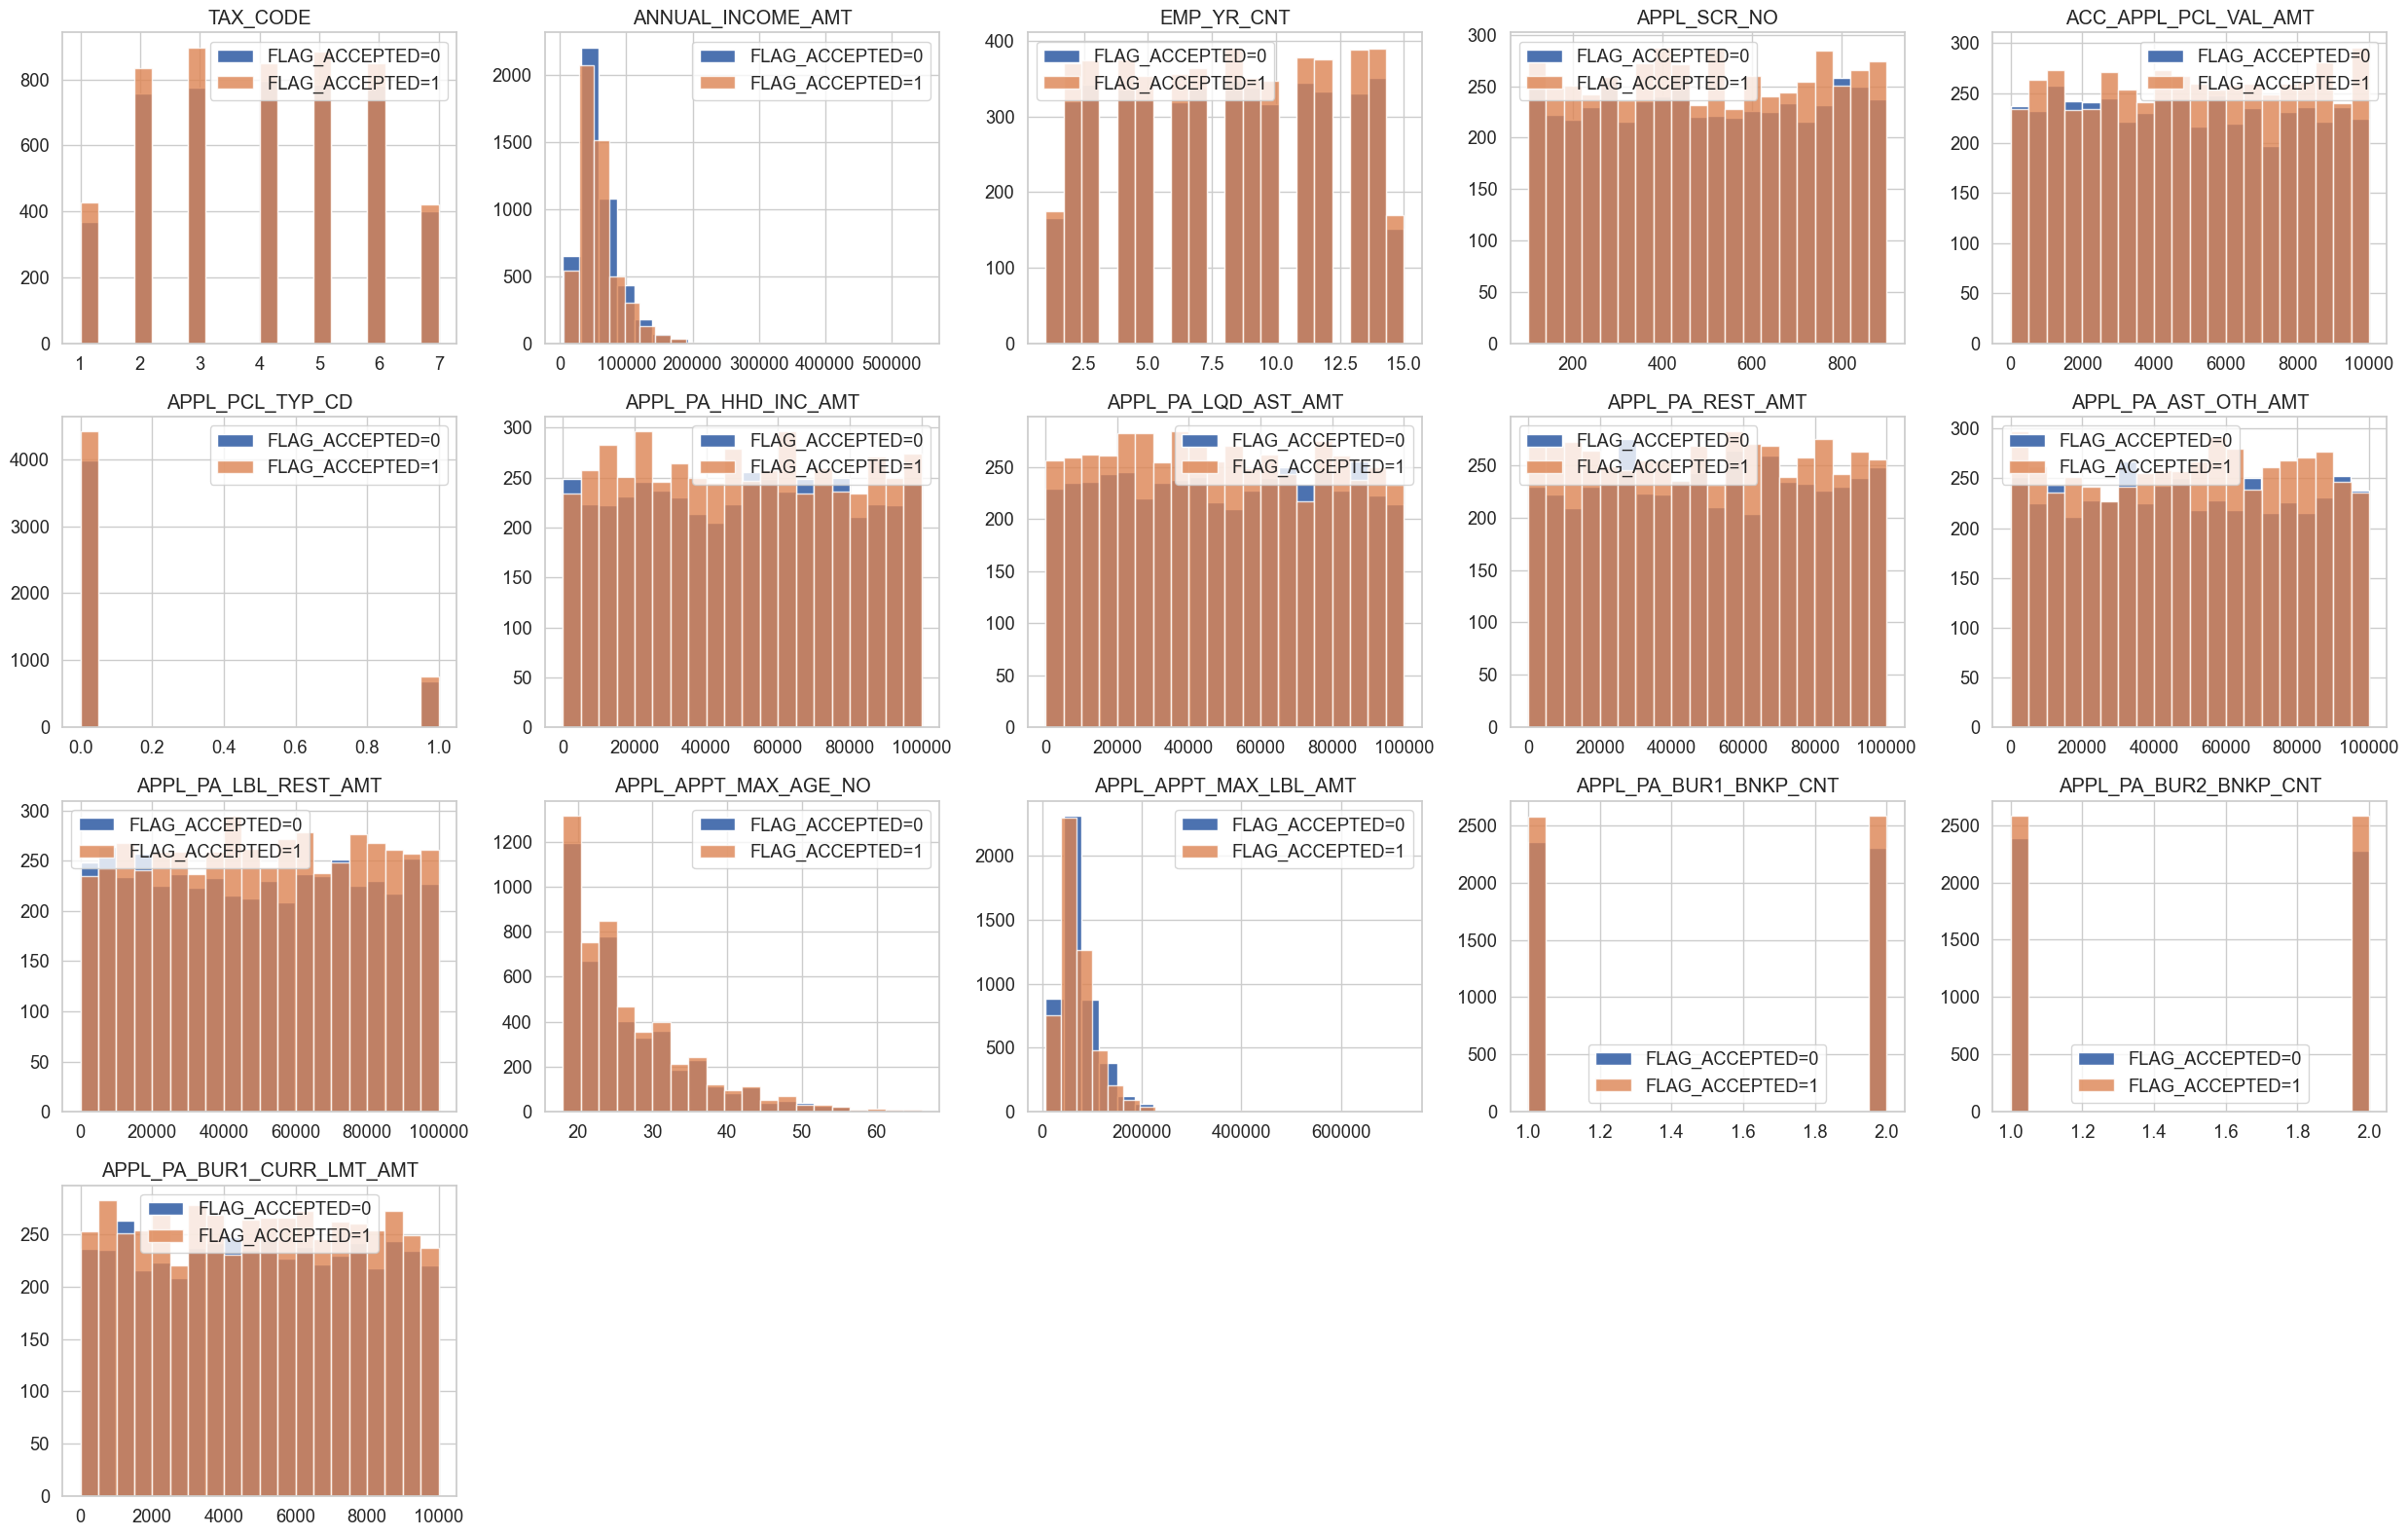

In [ ]:


# Exemplo de uso:
plot_histograms_by_flag(df_full, ['TAX_CODE', 'ANNUAL_INCOME_AMT', 'EMP_YR_CNT',
'APPL_SCR_NO', 'ACC_APPL_PCL_VAL_AMT',
'APPL_PCL_TYP_CD', 'APPL_PA_HHD_INC_AMT', 'APPL_PA_LQD_AST_AMT',
'APPL_PA_REST_AMT', 'APPL_PA_AST_OTH_AMT', 'APPL_PA_LBL_REST_AMT',
'APPL_APPT_MAX_AGE_NO', 'APPL_APPT_MAX_LBL_AMT',
'APPL_PA_BUR1_BNKP_CNT', 'APPL_PA_BUR2_BNKP_CNT',
'APPL_PA_BUR1_CURR_LMT_AMT'])

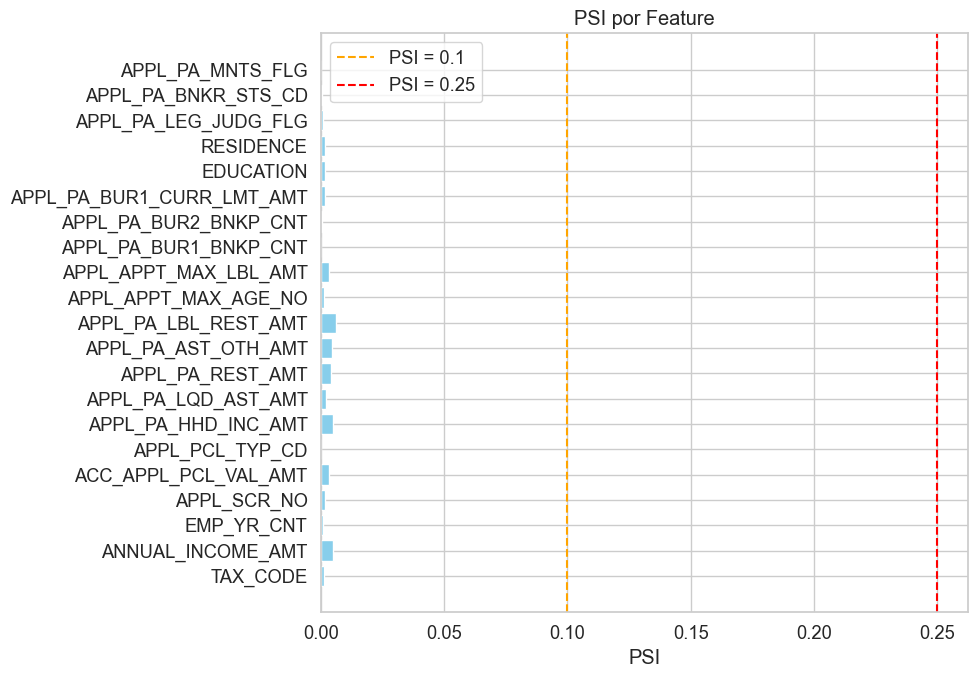

In [75]:
# Exemplo de uso:
psi(
    df_full,
    [
        'TAX_CODE', 'ANNUAL_INCOME_AMT', 'EMP_YR_CNT',
        'APPL_SCR_NO', 'ACC_APPL_PCL_VAL_AMT',
        'APPL_PCL_TYP_CD', 'APPL_PA_HHD_INC_AMT', 'APPL_PA_LQD_AST_AMT',
        'APPL_PA_REST_AMT', 'APPL_PA_AST_OTH_AMT', 'APPL_PA_LBL_REST_AMT',
        'APPL_APPT_MAX_AGE_NO', 'APPL_APPT_MAX_LBL_AMT',
        'APPL_PA_BUR1_BNKP_CNT', 'APPL_PA_BUR2_BNKP_CNT',
        'APPL_PA_BUR1_CURR_LMT_AMT',
        'EDUCATION', 'RESIDENCE', 'APPL_PA_LEG_JUDG_FLG', 'APPL_PA_BNKR_STS_CD', 'APPL_PA_MNTS_FLG'
    ],
    categorical_features=['EDUCATION', 'RESIDENCE', 'APPL_PA_LEG_JUDG_FLG', 'APPL_PA_BNKR_STS_CD', 'APPL_PA_MNTS_FLG']
)

#### Modelagem

In [53]:
df_approved_train, df_approved_test = train_test_split(df_full.loc[df_full['FLAG_ACCEPTED'] == 1],test_size=0.3,random_state=42)

X_train=df_approved_train.drop(['FLAG_ACCEPTED', 'TGT_VAR'],axis=1)
Y_train=df_approved_train['TGT_VAR']
X_test=df_approved_test.drop(['FLAG_ACCEPTED', 'TGT_VAR'],axis=1)
Y_test=df_approved_test['TGT_VAR']

In [90]:
woe_mappings = {}

num_features = ['TAX_CODE', 'ANNUAL_INCOME_AMT', 'EMP_YR_CNT',
        'APPL_SCR_NO', 'ACC_APPL_PCL_VAL_AMT',
        'APPL_PCL_TYP_CD', 'APPL_PA_HHD_INC_AMT', 'APPL_PA_LQD_AST_AMT',
        'APPL_PA_REST_AMT', 'APPL_PA_AST_OTH_AMT', 'APPL_PA_LBL_REST_AMT',
        'APPL_APPT_MAX_AGE_NO', 'APPL_APPT_MAX_LBL_AMT',
        'APPL_PA_BUR1_BNKP_CNT', 'APPL_PA_BUR2_BNKP_CNT',
        'APPL_PA_BUR1_CURR_LMT_AMT']

cat_features=['EDUCATION', 'RESIDENCE', 'APPL_PA_LEG_JUDG_FLG', 'APPL_PA_BNKR_STS_CD', 'APPL_PA_MNTS_FLG']

for feature in num_features:
    woe_table = optimal_binning_woe(df_approved_train, feature, 'TGT_VAR', modo='treino', n_bins=5)
    display(woe_table)
    woe_mappings[feature] = dict(zip(woe_table['bin'], woe_table['woe']))

for feature in cat_features:
    woe_table_cat = optimal_binning_woe(df_approved_train, feature, 'TGT_VAR', modo='treino', categorical_features=[feature])
    display(woe_table_cat)
    woe_mappings[feature] = dict(zip(woe_table_cat[feature], woe_table_cat['woe']))

,feature,bin,woe
0,TAX_CODE,"(0.999, 4.0]",0.0047
1,TAX_CODE,"(4.0, 7.0]",-0.0066


,feature,bin,woe
0,ANNUAL_INCOME_AMT,"(6446.999, 41985.333]",0.2940
1,ANNUAL_INCOME_AMT,"(41985.333, 62407.333]",-0.1306
2,ANNUAL_INCOME_AMT,"(62407.333, 326303.0]",-0.2186


,feature,bin,woe
0,EMP_YR_CNT,"(0.999, 8.0]",-0.0320
1,EMP_YR_CNT,"(8.0, 15.0]",0.0357


,feature,bin,woe
0,APPL_SCR_NO,"(99.999, 502.5]",-0.0400
1,APPL_SCR_NO,"(502.5, 900.0]",0.0388


,feature,bin,woe
0,ACC_APPL_PCL_VAL_AMT,"(-0.001, 5074.0]",-0.0023
1,ACC_APPL_PCL_VAL_AMT,"(5074.0, 9992.0]",0.0023


,feature,bin,woe
0,APPL_PCL_TYP_CD,"(-0.001, 1.0]",0.0000


,feature,bin,woe
0,APPL_PA_HHD_INC_AMT,"(39.999, 49276.0]",0.0115
1,APPL_PA_HHD_INC_AMT,"(49276.0, 99984.0]",-0.0116


,feature,bin,woe
0,APPL_PA_LQD_AST_AMT,"(-0.001, 32346.667]",-0.0427
1,APPL_PA_LQD_AST_AMT,"(32346.667, 65126.667]",0.0006
2,APPL_PA_LQD_AST_AMT,"(65126.667, 99960.0]",0.0408


,feature,bin,woe
0,APPL_PA_REST_AMT,"(75.999, 50120.0]",0.0388
1,APPL_PA_REST_AMT,"(50120.0, 99940.0]",-0.0400


,feature,bin,woe
0,APPL_PA_AST_OTH_AMT,"(7.999, 50610.0]",-0.0023
1,APPL_PA_AST_OTH_AMT,"(50610.0, 99984.0]",0.0023


,feature,bin,woe
0,APPL_PA_LBL_REST_AMT,"(35.999, 33932.0]",0.0741
1,APPL_PA_LBL_REST_AMT,"(33932.0, 66514.667]",-0.0204
2,APPL_PA_LBL_REST_AMT,"(66514.667, 100000.0]",-0.0571


,feature,bin,woe
0,APPL_APPT_MAX_AGE_NO,"(17.999, 24.0]",-0.0164
1,APPL_APPT_MAX_AGE_NO,"(24.0, 66.0]",0.0174


,feature,bin,woe
0,APPL_APPT_MAX_LBL_AMT,"(7547.999, 51093.333]",0.2243
1,APPL_APPT_MAX_LBL_AMT,"(51093.333, 76334.0]",-0.0346
2,APPL_APPT_MAX_LBL_AMT,"(76334.0, 433200.0]",-0.2268


,feature,bin,woe
0,APPL_PA_BUR1_BNKP_CNT,"(0.999, 2.0]",0.0000


,feature,bin,woe
0,APPL_PA_BUR2_BNKP_CNT,"(0.999, 2.0]",0.0000


,feature,bin,woe
0,APPL_PA_BUR1_CURR_LMT_AMT,"(3.999, 5020.0]",0.0606
1,APPL_PA_BUR1_CURR_LMT_AMT,"(5020.0, 9992.0]",-0.0634


,EDUCATION,woe
0,GRA,0.0167
1,HGR,0.0109
2,PGR,-0.0224
3,UGR,-0.0079


,RESIDENCE,woe
0,COM,-0.1318
1,OTH,0.1332
2,OWN,0.0499
3,REN,-0.0296


,APPL_PA_LEG_JUDG_FLG,woe
0,N,0.0067
1,Y,-0.1251


,APPL_PA_BNKR_STS_CD,woe
0,N,0.0060
1,Y,-0.6855


,APPL_PA_MNTS_FLG,woe
0,N,-0.0194
1,Y,0.2645


In [ ]:
for feature in num_features:
    bins = list(woe_mappings[feature].keys())
    woe_values = list(woe_mappings[feature].values())
    # Aplica np.select para cada linha
    conditions = [(X_train[feature].between(b.left, b.right, inclusive="left")) for b in bins]
    X_train[feature + '_woe'] = np.select(conditions, woe_values, default=np.nan)
    conditions = [(X_test[feature].between(b.left, b.right, inclusive="left")) for b in bins]
    X_test[feature + '_woe'] = np.select(conditions, woe_values, default=np.nan)

for feature in cat_features:
    X_train[feature + '_woe'] = X_train[feature].map(woe_mappings[feature])
    X_test[feature + '_woe'] = X_test[feature].map(woe_mappings[feature])

In [92]:
X_train

,TAX_CODE,ANNUAL_INCOME_AMT,EDUCATION,EMP_YR_CNT,RESIDENCE,APPL_SCR_NO,ACC_APPL_PCL_VAL_AMT,APPL_PCL_TYP_CD,APPL_PA_HHD_INC_AMT,APPL_PA_LQD_AST_AMT,APPL_PA_REST_AMT,APPL_PA_AST_OTH_AMT,APPL_PA_LBL_REST_AMT,APPL_PA_LEG_JUDG_FLG,APPL_PA_BNKR_STS_CD,APPL_PA_MNTS_FLG,APPL_APPT_MAX_AGE_NO,APPL_APPT_MAX_LBL_AMT,APPL_PA_BUR1_BNKP_CNT,APPL_PA_BUR2_BNKP_CNT,APPL_PA_BUR1_CURR_LMT_AMT,TAX_CODE_bin,TAX_CODE_woe,ANNUAL_INCOME_AMT_bin,ANNUAL_INCOME_AMT_woe,EMP_YR_CNT_bin,EMP_YR_CNT_woe,APPL_SCR_NO_bin,APPL_SCR_NO_woe,ACC_APPL_PCL_VAL_AMT_bin,ACC_APPL_PCL_VAL_AMT_woe,APPL_PCL_TYP_CD_bin,APPL_PCL_TYP_CD_woe,APPL_PA_HHD_INC_AMT_bin,APPL_PA_HHD_INC_AMT_woe,APPL_PA_LQD_AST_AMT_bin,APPL_PA_LQD_AST_AMT_woe,APPL_PA_REST_AMT_bin,APPL_PA_REST_AMT_woe,APPL_PA_AST_OTH_AMT_bin,APPL_PA_AST_OTH_AMT_woe,APPL_PA_LBL_REST_AMT_bin,APPL_PA_LBL_REST_AMT_woe,APPL_APPT_MAX_AGE_NO_bin,APPL_APPT_MAX_AGE_NO_woe,APPL_APPT_MAX_LBL_AMT_bin,APPL_APPT_MAX_LBL_AMT_woe,APPL_PA_BUR1_BNKP_CNT_bin,APPL_PA_BUR1_BNKP_CNT_woe,APPL_PA_BUR2_BNKP_CNT_bin,APPL_PA_BUR2_BNKP_CNT_woe,APPL_PA_BUR1_CURR_LMT_AMT_bin,APPL_PA_BUR1_CURR_LMT_AMT_woe,EDUCATION_woe,RESIDENCE_woe,APPL_PA_LEG_JUDG_FLG_woe,APPL_PA_BNKR_STS_CD_woe,APPL_PA_MNTS_FLG_woe
4657,7,52355.0000,0.0050,13,-0.0290,190,9968,0,32328,25104,21232,85020,35328,0.0030,0.0030,-0.0090,20,65913.0000,1,2,6684,"(4.0, 7.0]",-0.0066,"(41985.333, 62407.333]",-0.1306,"(8.0, 15.0]",0.0357,"(99.99799999999999, 502.5]",NaN,"(5074.0, 9992.0]",0.0023,"(-0.002, 1.0]",NaN,"(39.998000000000005, 49276.0]",NaN,"(-0.002, 32346.667]",NaN,"(75.99799999999999, 50120.0]",NaN,"(50610.0, 99984.0]",0.0023,"(33932.0, 66514.667]",-0.0204,"(17.997999999999998, 24.0]",NaN,"(51093.333, 76334.0]",-0.0346,"(0.998, 2.0]",NaN,"(0.998, 2.0]",NaN,"(5020.0, 9992.0]",-0.0634,NaN,NaN,NaN,NaN,NaN
2583,3,57190.0000,0.0050,9,-0.0290,837,2044,0,63132,64084,2716,26480,98892,0.0030,0.0030,-0.0090,18,68540.0000,2,2,924,"(0.998, 4.0]",NaN,"(41985.333, 62407.333]",-0.1306,"(8.0, 15.0]",0.0357,"(502.5, 900.0]",0.0388,"(-0.002, 5074.0]",NaN,"(-0.002, 1.0]",NaN,"(49276.0, 99984.0]",-0.0116,"(32346.667, 65126.667]",0.0006,"(75.99799999999999, 50120.0]",NaN,"(7.997999999999999, 50610.0]",NaN,"(66514.667, 100000.0]",-0.0571,"(17.997999999999998, 24.0]",NaN,"(51093.333, 76334.0]",-0.0346,"(0.998, 2.0]",NaN,"(0.998, 2.0]",NaN,"(3.998, 5020.0]",NaN,NaN,NaN,NaN,NaN,NaN
1829,1,44390.0000,-0.0010,6,-0.0290,104,7048,0,71948,93192,83764,1100,76492,0.0030,0.0030,-0.0090,27,49807.0000,1,1,6088,"(0.998, 4.0]",NaN,"(41985.333, 62407.333]",-0.1306,"(0.998, 8.0]",NaN,"(99.99799999999999, 502.5]",NaN,"(5074.0, 9992.0]",0.0023,"(-0.002, 1.0]",NaN,"(49276.0, 99984.0]",-0.0116,"(65126.667, 99960.0]",0.0408,"(50120.0, 99940.0]",-0.0400,"(7.997999999999999, 50610.0]",NaN,"(66514.667, 100000.0]",-0.0571,"(24.0, 66.0]",0.0174,"(7547.998, 51093.333]",NaN,"(0.998, 2.0]",NaN,"(0.998, 2.0]",NaN,"(5020.0, 9992.0]",-0.0634,NaN,NaN,NaN,NaN,NaN
4788,5,84560.0000,0.0050,5,-0.0290,245,5304,1,8760,28488,67828,2828,63400,0.0030,0.0030,-0.0090,19,96063.0000,2,2,1548,"(4.0, 7.0]",-0.0066,"(62407.333, 326303.0]",-0.2186,"(0.998, 8.0]",NaN,"(99.99799999999999, 502.5]",NaN,"(5074.0, 9992.0]",0.0023,"(-0.002, 1.0]",NaN,"(39.998000000000005, 49276.0]",NaN,"(-0.002, 32346.667]",NaN,"(50120.0, 99940.0]",-0.0400,"(7.997999999999999, 50610.0]",NaN,"(33932.0, 66514.667]",-0.0204,"(17.997999999999998, 24.0]",NaN,"(76334.0, 433200.0]",-0.2268,"(0.998, 2.0]",NaN,"(0.998, 2.0]",NaN,"(3.998, 5020.0]",NaN,NaN,NaN,NaN,NaN,NaN
2247,4,24452.0000,0.0050,10,0.0120,147,8272,0,50800,31444,49180,36908,78620,0.0030,0.0030,-0.0090,24,29717.0000,1,1,4064,"(0.998, 4.0]",NaN,"(6446.998, 41985.333]",NaN,"(8.0, 15.0]",0.0357,"(99.99799999999999, 502.5]",NaN,"(5074.0, 9992.0]",0.0023,"(-0.002, 1.0]",NaN,"(49276.0, 99984.0]",-0.0116,"(-0.002, 32346.667]",NaN,"(75.99799999999999, 50120.0]",NaN,"(7.997999999999999, 50610.0]",NaN,"(66514.667, 100000.0]",-0.0571,"(17.997999999999998, 24.0]",NaN,"(7547.998, 51093.333]",NaN,"(0.998, 2.0]",NaN,"(0.998, 2.0]",NaN

# <font color='orange' style='font-size: 40px;'> Exemplo Análise de Sobrevivência em Risco de Crédito </font>
<hr style='border: 2px solid orange;'>

https://www.kaggle.com/code/jurk06/survival-analysis/notebook

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>

In [ ]:
df_train = pd.read_csv('./data/cs-training.csv')
df_test = pd.read_csv('./data/cs-test.csv')

# <font color='orange' style='font-size: 40px;'> Exemplo Otimizador de Aprovação </font>
<hr style='border: 2px solid orange;'>

https://building.nubank.com/pt-br/ds-ml-meetup-n-o-82-do-nubank-imersao-pratica-nos-modelos-de-otimizacao/

# <font color='green' style='font-size: 30px;'> 1.1) Teste 1 </font>
<hr style='border: 2px solid green;'>